![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# стандартные библиотеки
import re
import json
from ast import literal_eval
from collections import Counter

# библиотеки для работы с данными
import numpy as np
import pandas as pd

# библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set()
%matplotlib inline

# методы для подготовки к обучению и обучения модели
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
def date_shorter (s):
    s=str(s)
    return s[s.find('], ['):s.find(']]')]

def comment (s):
    s=str(s)
    if (len(s) > 8) and  (s!=None) :
        return s[2:s.find('],')]
    else:
        return None

def circle_d (country):
    vals = country.values
    labels = country.index
    fig, ax = plt.subplots()
    ax.pie(vals, labels=labels)
    return ax.axis("equal")

def string_to_list(string):
    """Принимает список, представленный в виде строки и возвращает реальный список (объект с типом list)"""

    if type(string) != str or not string.startswith("[") and not string.endswith("]"):
        return None
    string = string.replace("nan", '""')

    return literal_eval(string)

#Справочник о городах
#Данные основаны на логических размышлениях и информации из гугл статистики
#Далее, во время анализа я выяснила, что последний комментарий был оставлен в феврале 2018
#Поэтому возьмем данные за 2018 год
city_info = {
        'Munich':
        {
            'capital': 0,
            'population': 1456000,
            'country': 'German'
            
        },
        'Oporto':
        {
            'capital': 0,
            'population': 214349,
            'country': 'Portuguese'
        },
        'Milan':
        {
            'capital': 0,
            'population': 1351562,
            'country': 'Italian'
        },
        'Barcelona':
        {
            'capital': 0,
            'population': 5515000,
            'country': 'Spanish'
        },
        'Zurich':
        {
            'capital': 0,
            'population': 428000,
            'country': 'Swiss'
        },
        'Lyon':
        {
            'capital': 0,
            'population': 515695,
            'country': 'French'
        },
        'Hamburg':
        {
            'capital': 0,
            'population': 1841179,
            'country': 'German'
        },
        'Geneva':
        {
            'capital': 0,
            'population': 495249,
            'country': 'Swiss'
        },
        'Krakow':
        {
            'capital': 0,
            'population': 779115,
            'country': 'Polish'
        },
        'Paris':
        {
            'capital': 1,
            'population': 2187000 ,
            'country': 'French'
        },
        'Stockholm':
        {
            'capital': 1,
            'population': 935000,
            'country': 'Swedish'
        },
        'London':
        {
            'capital': 1,
            'population': 8900000,
            'country': 'English'
        },
        'Berlin':
        {
            'capital': 1,
            'population': 3600000,
            'country': 'German'
        },
        'Bratislava':
        {
            'capital': 1,
            'population': 431214,
            'country': 'Slovakian'
        },
        'Vienna':
        {
            'capital': 1,
            'population': 1889000,
            'country': 'Austrian'
        },
        'Rome':
        {
            'capital': 1,
            'population': 2863843,
            'country': 'Italian'
        },
        'Madrid':
        {
            'capital': 1,
            'population': 6550000,
            'country': 'Spanish'
        },
        'Dublin':
        {
            'capital': 1,
            'population': 1361000,
            'country': 'Irish'
        },
        'Brussels':
        {
            'capital': 1,
            'population': 179277,
            'country': 'Belgian'
        },
        'Warsaw':
        {
            'capital': 1,
            'population': 1764615,
            'country': 'Ploish'
        },
        'Budapest':
        {
            'capital': 1,
            'population': 2965398,
            'country': 'Hungarian'
        },
        'Copenhagen':
        {
            'capital': 1,
            'population': 615993,
            'country': 'Danish'
        },
        'Amsterdam':
        {
            'capital': 1,
            'population': 872757,
            'country': 'Dutch'
        },
        'Lisbon':
        {
            'capital': 1,
            'population': 506654,
            'country': 'Portuguese',
        },
        'Prague':
        {
            'capital': 1,
            'population': 1295000,
            'country': 'Czech'
        },
        'Oslo':
        {
            'capital': 1,
            'population': 673469,
            'country': 'Norwegian'
        },
        'Helsinki':
        {
            'capital': 1,
            'population': 631695,
            'country': 'Finnish'
        },
        'Edinburgh':
        {
            'capital': 1,
            'population': 523538,
            'country': 'Scottish'
        },
        'Ljubljana':
        {
            'capital': 1,
            'population': 284000,
            'country': 'Slovenian'
        },
        'Athens':
        {
            'capital': 1,
            'population': 664046 ,
            'country': 'Greek'
        },
        'Luxembourg':
        {
            'capital': 1,
            'population': 122273,
            'country': 'Luxembourgish'
        }
    }

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com'
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
31481,id_3605,Berlin,"['German', 'Diner']",3607.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d13220144-Reviews-N...,d13220144,1,5.0
10248,id_778,Lisbon,"['Indian', 'Nepali', 'Vegetarian Friendly', 'V...",779.0,$,45.0,"[['Vast variety of dishes', 'Great indian rest...",/Restaurant_Review-g189158-d8729508-Reviews-An...,d8729508,1,4.5
35737,id_10802,London,"['Cafe', 'Fast Food', 'Vegetarian Friendly', '...",10812.0,$$ - $$$,20.0,"[['Clean and friendly.', 'Healthy lunch in St-...",/Restaurant_Review-g186338-d8873919-Reviews-Co...,d8873919,1,4.0
13842,id_1299,Paris,"['French', 'Cafe', 'European', 'Vegetarian Fri...",1300.0,$$ - $$$,291.0,"[['Worth the time', 'Nice cafe with good food ...",/Restaurant_Review-g187147-d1945721-Reviews-Ca...,d1945721,1,4.0
16988,id_2259,Prague,['Cafe'],2264.0,NaN,3.0,"[['nice restaurant', 'Good value lunch!'], ['0...",/Restaurant_Review-g274707-d7124189-Reviews-Ka...,d7124189,1,4.5


In [15]:
df.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак

In [16]:
#Переименуем колонки для удобства
df.columns=['Restaurant_id','City','Cuisine_Style','Ranking','Price_Range','NReviews','Reviews','URL_TA','ID_TA','sample','Rating']

# Rating. Посмотрим на целевую переменную

In [17]:
print(df.Rating.value_counts()) 



4.0    13692
4.5    10929
0.0    10000
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64


# **Колонка Restaurant_id**

In [18]:
#Посмотрим,есть ли в этой колонке пропуски
df.Restaurant_id.isna()[df.Restaurant_id.isna() ==True]

Series([], Name: Restaurant_id, dtype: bool)

In [19]:
#Пропусков нет, посмотрим, сколько здесь несетевых ресторанов
df.Restaurant_id.value_counts()[df.Restaurant_id.value_counts() ==1].count()

3807

In [20]:
# Создадим два колонки, судя по которым можно будет понять, сетевой это ресторан или нет
chain_restaurant_list = list(df.Restaurant_id.value_counts()[
                             df.Restaurant_id.value_counts() == 1].index)

chain_restaurant = []
for id in df.Restaurant_id:
    if id in chain_restaurant_list:
        chain_restaurant.append('Single_restaurant')
    else:
        chain_restaurant.append('Chain_restaurant')

df['Chain_or_not'] = chain_restaurant
df = pd.get_dummies(df, columns=['Chain_or_not'])
df.rename(columns={'Chain_or_not_Chain_restaurant': 'Chain_restaurant',
                   'Chain_or_not_Single_restaurant': 'Single_restaurant'}, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine_Style        38410 non-null object
Ranking              50000 non-null float64
Price_Range          32639 non-null object
NReviews             46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
Chain_restaurant     50000 non-null uint8
Single_restaurant    50000 non-null uint8
dtypes: float64(3), int64(1), object(7), uint8(2)
memory usage: 4.3+ MB


# Колонка City


In [22]:
#Посмотрим,есть ли в этой колонке пропуски
df.City.isna().value_counts()

False    50000
Name: City, dtype: int64

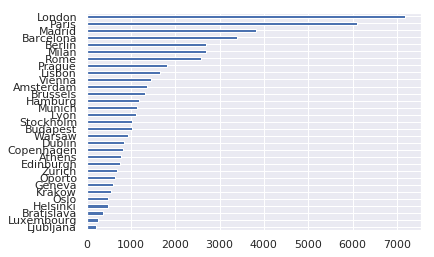

In [23]:
#Пропусков нет, хорошо
df["City"].value_counts(ascending=True).plot(kind="barh")
plt.show()
#Судя по графику, большая часть ресторанов из датафрейма пришлись на Лондон, Париж и Мадрид

In [24]:
df.City.value_counts().count()
#Городов не так много, всего 31. Можно разбить их по странам или выяснить, является ли город столицей или нет.

31

In [25]:
#Создадим список, в котором значение 1 будет означать Столицу, значение 0 - провинциальный город.
#Для данного датасета это, конечно, весьма условно, так как Мюнхен -это, конечно, не столица Германии, но туристический центр
#Поэтому ожидания от качества ресторанов там не меньше, а конкуренция и подавно,но все же.
Capital = df['City'].apply(lambda x: city_info[x]['capital'])
df['Capital']=Capital
df = pd.get_dummies(df, columns=['Capital'])
df.rename(columns={'Capital_0': 'Not_Capital',
                   'Capital_1': 'Capital'}, inplace=True)

In [26]:
#Добавим еще информацию о стране
Country_name= df['City'].apply(lambda x: city_info[x]['country'])
df['Country_name']=Country_name
df['Country_name'].value_counts().count()

24

# Колонка Cuisine_Style

In [27]:
#Эта колонка по факту является списком, переделаем ее в список
df['Cuisine_Style_old']=df['Cuisine_Style']
df['Cuisine_Style'] = df['Cuisine_Style'].apply(string_to_list)
cuisine_styles = df.explode("Cuisine_Style")["Cuisine_Style"]
Qcuisines = cuisine_styles.value_counts().count()
cuisine_styles.value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Fujian                     2
Salvadoran                 1
Xinjiang                   1
Latvian                    1
Burmese                    1
Name: Cuisine_Style, Length: 125, dtype: int64

In [28]:
#Добавим колонку, в которой будеn содержаться информация о кол-ве кухонь, если не заполнено, пишу 2(медиана)
Cuisines_q=[]
for cuisine in df.Cuisine_Style:
    if cuisine != None:
        Cuisines_q.append(len(cuisine))
    else:
        Cuisines_q.append(2)

df['Cuisines_q']=Cuisines_q
df['Cuisines_q']

0        2
1        5
2        1
3        5
4        6
        ..
49995    4
49996    5
49997    2
49998    5
49999    1
Name: Cuisines_q, Length: 50000, dtype: int64

In [29]:
#Выберем 10 наиболее популярных кухонь и добавим их в наш датафрейм
cuisine_styles.value_counts().head(10)

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Name: Cuisine_Style, dtype: int64

In [30]:
#Выделим новую колонку с самыми популярными кухнями Vegetarian Friendly
df['VF']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Vegetarian Friendly',regex=False) == True),'VF']=1

In [31]:
#Выделим новую колонку с самыми популярными кухнями European
df['European']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('European',regex=False) == True),'European']=1

In [32]:
#Выделим новую колонку с самыми популярными кухнями Mediterranean
df['Mediterranean']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Mediterranean',regex=False) == True),'Mediterranean']=1

In [33]:
#Выделим новую колонку с самыми популярными кухнями Italian
df['Italian']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Italian',regex=False) == True),'Italian']=1

In [34]:
#Выделим новую колонку с самыми популярными кухнями Vegan Options
df['Vegan Options']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Vegan Options',regex=False) == True),'Vegan Options']=1

In [35]:
#Выделим новую колонку с самыми популярными кухнями Gluten Free Options  
df['Gluten Free Options']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Gluten Free Options',regex=False) == True),'Gluten Free Options']=1

In [36]:
#Выделим новую колонку с самыми популярными кухнями Bar
df['Bar']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Bar',regex=False) == True),'Bar']=1


In [37]:
#Выделим новую колонку с самыми популярными кухнями French
df['French']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('French',regex=False) == True),'French']=1

In [38]:
#Выделим новую колонку с самыми популярными кухнями Asian
df['Asian']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Asian',regex=False) == True),'Asian']=1

In [39]:
#Выделим новую колонку с самыми популярными кухнями Pizza
df['Pizza']=0
df.loc[(df.Cuisine_Style_old.isna()== False) &
       (df.Cuisine_Style_old.str.contains('Pizza',regex=False) == True),'Pizza']=1

В этом столбце очень много пропусков с данными. Вернемся к нему чуть позднее, после того, как обработаем остальные столбцы.

# Колонка Ranking


In [40]:
#Проверим данные на пропуски
df.Ranking.isna().value_counts()
#Пропусков нет

False    50000
Name: Ranking, dtype: int64

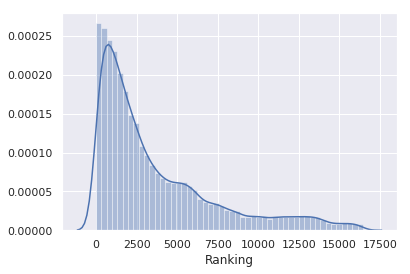

In [41]:
sns.distplot(df.Ranking)
#Переменная Ranking имеет большой разброс по значению, чтобы уменьшить его, логарифмируем данные

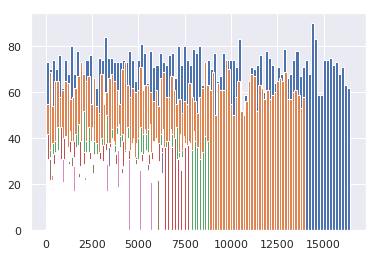

In [42]:
# посмотрим на топ 10 городов
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.
Исправим ситуация, выровняв этот показатель по кол-ву ресторанов

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
Restaurant_id          50000 non-null object
City                   50000 non-null object
Cuisine_Style          38410 non-null object
Ranking                50000 non-null float64
Price_Range            32639 non-null object
NReviews               46800 non-null float64
Reviews                49998 non-null object
URL_TA                 50000 non-null object
ID_TA                  50000 non-null object
sample                 50000 non-null int64
Rating                 50000 non-null float64
Chain_restaurant       50000 non-null uint8
Single_restaurant      50000 non-null uint8
Not_Capital            50000 non-null uint8
Capital                50000 non-null uint8
Country_name           50000 non-null object
Cuisine_Style_old      38410 non-null object
Cuisines_q             50000 non-null int64
VF                     50000 non-null int64
European               50000 non-null in

In [44]:
#выясняем кол-во ресторанов в каждом городе и добавляем их в словарик, где содержится информация о городах
cities=df.City.value_counts().index

for city in cities:
    city_info[city]["Nrestaurants"]=df[df.City == city].ID_TA.count()
city_info

{'Munich': {'capital': 0,
  'population': 1456000,
  'country': 'German',
  'Nrestaurants': 1145},
 'Oporto': {'capital': 0,
  'population': 214349,
  'country': 'Portuguese',
  'Nrestaurants': 642},
 'Milan': {'capital': 0,
  'population': 1351562,
  'country': 'Italian',
  'Nrestaurants': 2694},
 'Barcelona': {'capital': 0,
  'population': 5515000,
  'country': 'Spanish',
  'Nrestaurants': 3395},
 'Zurich': {'capital': 0,
  'population': 428000,
  'country': 'Swiss',
  'Nrestaurants': 685},
 'Lyon': {'capital': 0,
  'population': 515695,
  'country': 'French',
  'Nrestaurants': 1126},
 'Hamburg': {'capital': 0,
  'population': 1841179,
  'country': 'German',
  'Nrestaurants': 1186},
 'Geneva': {'capital': 0,
  'population': 495249,
  'country': 'Swiss',
  'Nrestaurants': 590},
 'Krakow': {'capital': 0,
  'population': 779115,
  'country': 'Polish',
  'Nrestaurants': 554},
 'Paris': {'capital': 1,
  'population': 2187000,
  'country': 'French',
  'Nrestaurants': 6108},
 'Stockholm': {

In [45]:
#Добавляем колонку,с кол-вом ресторанов для каждого города
df['Nrestaurants'] = df['City'].apply(lambda x: city_info[x]['Nrestaurants'])

In [46]:
#Добавляем новую колонку Ranking_per_city
df['Ranking_per_city'] = df['Ranking'] / df['Nrestaurants']

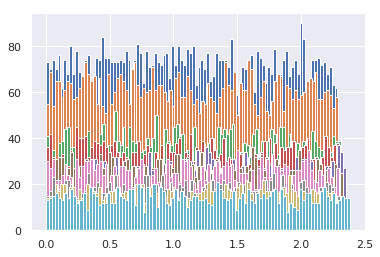

In [47]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking_per_city'][df['City'] == x].hist(bins=100)
plt.show()

Признак без пропусков. Распределение в целом идентичное для каждого города.

# Колонка Price_Range

In [48]:
#Посмотрим, как она выглядит
df.Price_Range.value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_Range, dtype: int64

In [49]:
#В данной колонке только три варианта значений (пропуски пока не смотрим)
#Заменим значения в колонке на условное кол-во звед, где 1 зведочка - дешевый ресторан, 3 звездочки- дорогой

# создадим словарь для конвертации значений
price_range_dict = dict(zip(['$$ - $$$', '$', '$$$$'], [500, 5, 5000]))

df['Price_Range'] = df['Price_Range'].replace(to_replace=price_range_dict)


In [50]:
#Теперь посмотрим на пропуски
df.Price_Range.isna().value_counts()
#17361 пропущенных значений. У сетевых ресторанов должна быть одна ценовая категория. Проверим.

False    32639
True     17361
Name: Price_Range, dtype: int64

In [51]:
df[(df.Price_Range.isna() == True) & df.Chain_restaurant == 1]

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,Reviews,URL_TA,ID_TA,sample,...,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Nrestaurants,Ranking_per_city
7,id_7,Budapest,None,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,...,0,0,0,0,0,0,0,0,1021,2.282076
8,id_8,Helsinki,"[European, Scandinavian]",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,...,0,0,0,0,0,0,0,0,475,1.623158
9,id_9,Stockholm,[Italian],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,...,0,1,0,0,0,0,0,0,1033,0.585673
10,id_10,Rome,None,1209.0,NaN,306.0,"[['Very pretentious, but drinks are top notch'...",/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,...,0,0,0,0,0,0,0,0,2589,0.466976
13,id_13,Hamburg,None,1000.0,NaN,30.0,"[['Surprisingly good pizza', 'Yummy'], ['09/28...",/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,...,0,0,0,0,0,0,0,0,1186,0.843170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49988,id_4968,Berlin,None,4970.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,...,0,0,0,0,0,0,0,0,2705,1.837338
49989,id_8887,London,[International],8896.0,NaN,NaN,"[['I love this place!'], ['08/24/2015']]",/Restaurant_Review-g186338-d5550626-Reviews-Th...,d5550626,1,...,0,0,0,0,0,0,0,0,7193,1.236758
49990,id_1187,Oporto,"[European, Portuguese]",1188.0,NaN,14.0,"[['Traditional ""home cooked"" food for an ""eco....",/Restaurant_Review-g189180-d3612719-Reviews-D_...,d3612719,1,...,0,0,0,0,0,0,0,0,642,1.850467
49993,id_6057,Paris,None,6058.0,NaN,16.0,"[['Naught but VERY nice', 'Yum'], ['01/23/2017...",/Restaurant_Review-g187147-d10532509-Reviews-B...,d10532509,1,...,0,0,0,0,0,0,0,0,6108,0.991814


In [52]:
# проверяем на первом и догадка не подтвердилась, у них даже кухни разные
df[df.Restaurant_id == 'id_7']

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,Reviews,URL_TA,ID_TA,sample,...,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Nrestaurants,Ranking_per_city
7,id_7,Budapest,None,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,...,0,0,0,0,0,0,0,0,1021,2.282076
14629,id_7,Hamburg,"[Seafood, Mediterranean, European, Spanish, Po...",8.0,500.0,764.0,"[['The best meal I had in Hamburg!', '""Mi cass...",/Restaurant_Review-g187331-d7171165-Reviews-Ca...,d7171165,1,...,1,0,0,1,0,0,0,0,1186,0.006745
15648,id_7,Dublin,"[Mediterranean, European, Spanish, Vegetarian ...",8.0,500.0,832.0,"[['Delicious', 'Highly recommended.'], ['01/02...",/Restaurant_Review-g186605-d4234586-Reviews-La...,d4234586,1,...,1,0,1,1,0,0,0,0,836,0.009569
16865,id_7,Amsterdam,"[Asian, Indonesian, Vegetarian Friendly, Vegan...",8.0,5000.0,675.0,"[['Great Experience', 'A true delight'], ['01/...",/Restaurant_Review-g188590-d697058-Reviews-Blu...,d697058,1,...,0,0,1,1,0,0,1,0,1372,0.005831
19997,id_7,Lisbon,"[European, Portuguese, French, Wine Bar, Veget...",8.0,500.0,706.0,"[['Perfect place', 'Great Place!'], ['02/03/20...",/Restaurant_Review-g189158-d4955432-Reviews-Au...,d4955432,1,...,0,0,1,0,1,1,0,0,1647,0.004857
25549,id_7,Warsaw,"[Indian, Asian, Healthy, Balti, Wine Bar, Vege...",8.0,500.0,468.0,"[['Nice Food', 'Just what I needed'], ['01/03/...",/Restaurant_Review-g274856-d5893468-Reviews-Mr...,d5893468,1,...,0,0,1,1,1,0,1,0,925,0.008649
29396,id_7,Milan,"[Japanese, Seafood, Sushi, Asian, Soups, Fusio...",8.0,5000.0,2487.0,"[['Eden in Japan', '""An amazing visit at a ama...",/Restaurant_Review-g187849-d1675094-Reviews-Iy...,d1675094,1,...,0,0,1,1,0,0,1,0,2694,0.002970
31191,id_7,Zurich,"[Swiss, European, Central European, Vegetarian...",8.0,5000.0,492.0,"[['Wonderful traditional Swiss restaurant', 'G...",/Restaurant_Review-g188113-d802913-Reviews-Kin...,d802913,1,...,0,0,1,1,0,0,0,0,685,0.011679
31770,id_7,Oporto,"[European, Portuguese, Wine Bar]",8.0,500.0,345.0,"[['Wine tasting and tapas at lovely bar', 'Sup...",/Restaurant_Review-g189180-d8141123-Reviews-Ba...,d8141123,1,...,0,0,0,0,1,0,0,0,642,0.012461
32550,id_7,Helsinki,"[Vegetarian Friendly, Gluten Free Options]",8.0,500.0,767.0,"[['Little Gem', 'Authentic Finnish Cuisine'], ...",/Restaurant_Review-g189934-d1064110-Reviews-Ko...,d1064110,1,...,0,0,0,1,0,0,0,0,475,0.016842


# Колонка NReviews

In [53]:
#Посмотрим пропуски
df.NReviews.isna().value_counts()
#Посмотрим на эти пропущенные значения

False    46800
True      3200
Name: NReviews, dtype: int64

In [54]:
df[df.NReviews.isna() == True].sample(5)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,Reviews,URL_TA,ID_TA,sample,...,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Nrestaurants,Ranking_per_city
29521,id_5946,Madrid,"[Bar, Spanish, Pub]",5949.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d12353342-Reviews-L...,d12353342,1,...,0,0,0,0,1,0,0,0,3813,1.560189
45985,id_573,Helsinki,None,574.0,NaN,NaN,"[['An art gallery+restaurant, a great place f....",/Restaurant_Review-g189934-d12869413-Reviews-R...,d12869413,1,...,0,0,0,0,0,0,0,0,475,1.208421
22851,id_3729,Prague,"[European, Diner, Czech]",3738.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274707-d7124168-Reviews-Me...,d7124168,1,...,0,0,0,0,0,0,0,0,1816,2.058370
48699,id_1087,Stockholm,[Indian],1088.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189852-d2311079-Reviews-Fl...,d2311079,1,...,0,0,0,0,0,0,0,0,1033,1.053243
38568,id_1189,Copenhagen,None,1183.0,NaN,NaN,"[['Best cortado ever'], ['11/11/2017']]",/Restaurant_Review-g189541-d13007244-Reviews-K...,d13007244,1,...,0,0,0,0,0,0,0,0,819,1.444444


In [55]:
# Явным образом, видно, что у некоторых ресторанов с неизвестным показателем кол-ва отзывов есть хотя бы один отзыв.
# Вернемся к ним чуть позднее, когда обработаем ту колонку, в которой есть информация о самих отзывах


# Reviews

Самая замусоренная колонка из всех, но содержит очень много данных.

In [56]:
#Для натачала вытащим даты комментариев
df['date']=df.Reviews.apply(date_shorter)
data_s=[]

for date in df.date:
    date=date.replace('], [','')
    data_s.append(date)
    
df['date']=data_s
df.loc[df['date'] == '','date']=None

In [57]:
df['date']

0                              None
1        '12/05/2017', '10/29/2017'
2        '12/28/2017', '12/06/2017'
3        '12/06/2017', '11/22/2017'
4        '02/08/2018', '01/24/2018'
                    ...            
49995    '12/16/2017', '11/12/2017'
49996    '12/21/2017', '12/12/2017'
49997    '11/03/2016', '04/12/2008'
49998    '07/11/2017', '06/18/2017'
49999    '01/31/2016', '07/04/2012'
Name: date, Length: 50000, dtype: object

In [58]:
#Формируем из имеющегося списка два стобика с первой датой и со второй датой
date1=[]
date2=[]

for date in df.date:
    if date!= None:
        date1.append(date.split(sep=', ')[0])
    else:
        date1.append(float('nan'))
        
for date in df.date:
    if (date!= None) and (len(date.split(sep=', ')) == 2):
        date2.append(date.split(sep=', ')[1])
    else:
        date2.append(float('nan'))

In [59]:
df['FirstCommentdt']=date2
df['SecondCommentdt']=date1

df.loc[df.FirstCommentdt == 'None','FirstCommentdt']= float('nan')
df.loc[df.SecondCommentdt == 'None','SecondCommentdt']= float('nan')

df['FirstCommentdt']=df['FirstCommentdt'].str.replace("'", "")
df['SecondCommentdt']=df['SecondCommentdt'].str.replace("'", "")

In [60]:
df['SecondCommentdt']

0               NaN
1        12/05/2017
2        12/28/2017
3        12/06/2017
4        02/08/2018
            ...    
49995    12/16/2017
49996    12/21/2017
49997    11/03/2016
49998    07/11/2017
49999    01/31/2016
Name: SecondCommentdt, Length: 50000, dtype: object

In [61]:
df['FirstCommentdt']=pd.to_datetime(df['FirstCommentdt'], format='%m/%d/%Y')
df['SecondCommentdt']=pd.to_datetime(df['SecondCommentdt'], format='%m/%d/%Y')

In [62]:
#Введем еще одну колонку, в которой будет информация о разнице в днях
df['TimeDistance']=abs(df['SecondCommentdt']-df['FirstCommentdt'])
df.TimeDistance=df.TimeDistance.dt.days 


In [63]:
#Узнаем, насколько данные свежие,по дате последнего комментария
df['FirstCommentdt'].max()

Timestamp('2018-02-26 00:00:00')

In [64]:
df['SecondCommentdt'].max()

Timestamp('2018-02-26 00:00:00')

In [65]:
df=df.drop(['date'], axis=1)

In [66]:
df.sample(10)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,Reviews,URL_TA,ID_TA,sample,...,Gluten Free Options,Bar,French,Asian,Pizza,Nrestaurants,Ranking_per_city,FirstCommentdt,SecondCommentdt,TimeDistance
33514,id_2132,Barcelona,[Japanese],2133.0,500.0,28.0,"[['Definitely worth a visit', 'Japanese restau...",/Restaurant_Review-g187497-d11905807-Reviews-K...,d11905807,1,...,0,0,0,0,0,3395,0.628277,2017-06-25,2017-10-15,112.0
46148,id_648,Dublin,"[American, Irish, European, Vegetarian Friendl...",649.0,500.0,64.0,"[['Great Brunch Spot', 'Amazing food'], ['01/0...",/Restaurant_Review-g186605-d10682505-Reviews-F...,d10682505,1,...,0,0,0,0,0,836,0.776316,2017-08-20,2018-01-04,137.0
42958,id_2479,Brussels,"[Chinese, European]",2480.0,NaN,4.0,"[['Quick Ready Service', 'Great food but not m...",/Restaurant_Review-g950777-d7196005-Reviews-Le...,d7196005,1,...,0,0,0,0,0,1314,1.887367,2015-05-02,2016-06-19,414.0
4382,id_4382,Paris,"[French, International, Vegetarian Friendly]",2850.0,500.0,18.0,"[['Very good, very nice people, very trendy'],...",/Restaurant_Review-g187147-d12664128-Reviews-D...,d12664128,0,...,0,0,1,0,0,6108,0.466601,NaT,2017-12-15,NaN
38806,id_1937,Berlin,[Mexican],1939.0,5.0,32.0,"[['Best meal we had in Berlin', 'Medium qualit...",/Restaurant_Review-g187323-d8708451-Reviews-Po...,d8708451,1,...,0,0,0,0,0,2705,0.716821,2017-08-08,2017-08-26,18.0
10188,id_3053,Rome,"[Italian, European, Mediterranean]",3054.0,500.0,177.0,"[['Super friendly owner, nice little place', '...",/Restaurant_Review-g187791-d7214349-Reviews-Sh...,d7214349,1,...,0,0,0,0,0,2589,1.179606,2017-06-26,2017-07-05,9.0
41097,id_1545,Brussels,None,1602.0,NaN,2.0,"[[], []]",/Restaurant_Review-g1136497-d12083432-Reviews-...,d12083432,1,...,0,0,0,0,0,1314,1.219178,NaT,NaT,NaN
25047,id_285,Oslo,"[Japanese, Sushi, Asian, Vegetarian Friendly, ...",286.0,500.0,121.0,"[['Friendly and quick service - good food', 'G...",/Restaurant_Review-g190479-d1026791-Reviews-Su...,d1026791,1,...,1,0,0,1,0,488,0.586066,2017-07-29,2017-10-23,86.0
1917,id_1917,Vienna,[Chinese],2091.0,5.0,6.0,"[['Excellent value for the money', 'Rise resta...",/Restaurant_Review-g190454-d4782335-Reviews-Ri...,d4782335,0,...,0,0,0,0,0,1443,1.449064,2016-08-23,2016-11-02,71.0
45616,id_2178,London,None,2183.0,NaN,261.0,"[['Happy Hour', 'Cocktail masterclass was good...",/Restaurant_Review-g186338-d1501587-Reviews-Lo...,d1501587,1,...,0,0,0,0,0,7193,0.303490,2017-12-15,2017-12-28,13.0


In [67]:
#Формируем из колонки Reviews две колонки с комментариями
df.Reviews=df.Reviews.apply(lambda x: str(x)[2:-2])
df.Reviews=df.Reviews.apply(lambda x: (str(x).split(sep='], [')[0]).split(sep= "', '"))

def get_com1(x):
    if x[0]=='':
        return None
    else:
        return x[0].replace("'","")

def get_com2(x):
    if x[-1]=='' or x[-1]==x[0]:
        return None
    else:
        return x[-1].replace("'","")

df['FirstComment']=df.Reviews.apply(get_com1)
df['SecondComment']=df.Reviews.apply(get_com2)
display(df)

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,Reviews,URL_TA,ID_TA,sample,...,French,Asian,Pizza,Nrestaurants,Ranking_per_city,FirstCommentdt,SecondCommentdt,TimeDistance,FirstComment,SecondComment
0,id_0,Paris,"[Bar, Pub]",12963.0,500.0,4.0,[],/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,0,0,0,6108,2.122299,NaT,NaT,NaN,None,None
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,500.0,97.0,"['Very good reviews!, Fine dining in Hakaniemi']",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0,0,0,475,0.223158,2017-10-29,2017-12-05,37.0,Very good reviews!,Fine dining in Hakaniemi
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,500.0,28.0,"['Better than the Links, Ivy Black']",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,0,0,0,745,1.087248,2017-12-06,2017-12-28,22.0,Better than the Links,Ivy Black
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,5000.0,202.0,"['Most exquisite, Delicious and authentic']",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,0,0,0,7193,0.232031,2017-11-22,2017-12-06,14.0,Most exquisite,Delicious and authentic
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,5000.0,162.0,"['Always the best in bratislava, Very good but...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0,0,0,380,0.097368,2018-01-24,2018-02-08,15.0,Always the best in bratislava,Very good but pricey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,500.0,79.0,"['The real Italian experience!, Wonderful food...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,...,0,0,0,2694,0.185598,2017-11-12,2017-12-16,34.0,The real Italian experience!,"Wonderful food, wonderful experience"
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,500.0,542.0,"['Parisian atmosphere, Bit pricey but interest...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,...,1,0,0,6108,1.038147,2017-12-12,2017-12-21,9.0,Parisian atmosphere,Bit pricey but interesting decor and good...
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,NaN,4.0,"['Good by swedish standards, A hidden jewel in...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,...,0,0,0,1033,1.599226,2008-04-12,2016-11-03,3127.0,Good by swedish standards,A hidden jewel in the middle of Västertorp...
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,500.0,70.0,"['Underground restaurant, Oldest Restaurant in...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,...,0,0,0,925,0.692973,2017-06-18,2017-07-11,23.0,Underground restaurant,Oldest Restaurant in Warsaw


In [68]:
df['FirstComment']=df['FirstComment'].str.lower()
df['SecondComment']=df['SecondComment'].str.lower()

In [69]:
#Теперь можно смело избавиться от лишних стобцов
df=df.drop(['Reviews'], axis=1)


In [70]:
#Самое время понять, зачем мы это делали)
#А делала я это потому что хотела узнать среднюю длину комментария
Averagelen1=[]
Averagelen2=[]
for comment in df['FirstComment']:
    if comment!= None:
        Averagelen1.append(len(comment))
    else:
        Averagelen1.append(None)
        
for comment in df['SecondComment']:
    if comment!= None:
        Averagelen2.append(len(comment))
    else:
        Averagelen2.append(None)

#Получаем длину комментария в первом столбике 
df['Averagelen1']=Averagelen1
df['Averagelen2']=Averagelen2

In [71]:
#Cредняя длина комментария 
df['Averagel']= (df['Averagelen1'].mean(skipna = True)+df['Averagelen2'].mean(skipna = True))/2.0

In [72]:
df.loc[(df.Averagelen1.isna() == True),'Averagelen1']=0
df.loc[(df.Averagelen2.isna() == True),'Averagelen2']=0

# Колонка URL_TA

In [73]:
# Проверяем на пропуски
df.URL_TA.isna().value_counts()

False    50000
Name: URL_TA, dtype: int64

In [74]:
# Пропусков нет, но есть дубли, похоже, что некоторые рестораны зарегистрированы дважды, таких дублей 37 штук
df.URL_TA.value_counts().value_counts()

1    49926
2       37
Name: URL_TA, dtype: int64

In [75]:
#Удалим эти дубли
df.drop_duplicates(subset='URL_TA')

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,URL_TA,ID_TA,sample,Rating,...,Nrestaurants,Ranking_per_city,FirstCommentdt,SecondCommentdt,TimeDistance,FirstComment,SecondComment,Averagelen1,Averagelen2,Averagel
0,id_0,Paris,"[Bar, Pub]",12963.0,500.0,4.0,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,6108,2.122299,NaT,NaT,NaN,None,None,0.0,0.0,24.2545
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,500.0,97.0,/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,475,0.223158,2017-10-29,2017-12-05,37.0,very good reviews!,fine dining in hakaniemi,18.0,24.0,24.2545
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,500.0,28.0,/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,745,1.087248,2017-12-06,2017-12-28,22.0,better than the links,ivy black,21.0,9.0,24.2545
3,id_3,London,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,5000.0,202.0,/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,7193,0.232031,2017-11-22,2017-12-06,14.0,most exquisite,delicious and authentic,14.0,23.0,24.2545
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,5000.0,162.0,/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,380,0.097368,2018-01-24,2018-02-08,15.0,always the best in bratislava,very good but pricey,29.0,20.0,24.2545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,500.0,79.0,/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,2694,0.185598,2017-11-12,2017-12-16,34.0,the real italian experience!,"wonderful food, wonderful experience",28.0,36.0,24.2545
49996,id_6340,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,500.0,542.0,/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,6108,1.038147,2017-12-12,2017-12-21,9.0,parisian atmosphere,bit pricey but interesting decor and good...,19.0,44.0,24.2545
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,NaN,4.0,/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,1033,1.599226,2008-04-12,2016-11-03,3127.0,good by swedish standards,a hidden jewel in the middle of västertorp...,25.0,45.0,24.2545
49998,id_640,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,500.0,70.0,/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,925,0.692973,2017-06-18,2017-07-11,23.0,underground restaurant,oldest restaurant in warsaw,22.0,27.0,24.2545


# Новые переменные на основе дополнительных данных

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 37 columns):
Restaurant_id          50000 non-null object
City                   50000 non-null object
Cuisine_Style          38410 non-null object
Ranking                50000 non-null float64
Price_Range            32639 non-null float64
NReviews               46800 non-null float64
URL_TA                 50000 non-null object
ID_TA                  50000 non-null object
sample                 50000 non-null int64
Rating                 50000 non-null float64
Chain_restaurant       50000 non-null uint8
Single_restaurant      50000 non-null uint8
Not_Capital            50000 non-null uint8
Capital                50000 non-null uint8
Country_name           50000 non-null object
Cuisine_Style_old      38410 non-null object
Cuisines_q             50000 non-null int64
VF                     50000 non-null int64
European               50000 non-null int64
Mediterranean          50000 non-null in

In [77]:
#Добавим в датафрем колонку с кол-вом населения городов
df['Population'] = df['City'].apply(lambda x: city_info[x]['population'])

In [78]:
#Добавим в датафрем данные о кол-ве ресторанов на человека
df['Restaurant_per_person'] = df['Nrestaurants'] / df['Population']


In [79]:
# Добавляем колонку с кол-вом комментариев на человека
df['Comment_per_person'] = df['NReviews'] / df['Population']

# Заполнение пропусков

# Колонка NReviews

In [80]:
#Заполним колонку NReviews на основании колонок первого и второго комментария. Будем считать, что если в строке пропуск, а один комментарий есть, значит значение будет =1, если оба есть, то 2, если нет, то 0
df[df.NReviews.isna() == True]

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,URL_TA,ID_TA,sample,Rating,...,SecondCommentdt,TimeDistance,FirstComment,SecondComment,Averagelen1,Averagelen2,Averagel,Population,Restaurant_per_person,Comment_per_person
7,id_7,Budapest,None,2330.0,NaN,NaN,/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,2965398,0.000344,NaN
25,id_25,Madrid,None,5828.0,NaN,NaN,/Restaurant_Review-g187514-d13202032-Reviews-W...,d13202032,0,0.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,6550000,0.000582,NaN
53,id_53,Prague,None,2095.0,NaN,NaN,/Restaurant_Review-g274707-d7124128-Reviews-Ch...,d7124128,0,0.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,1295000,0.001402,NaN
74,id_74,Prague,"[Cafe, European, Czech]",2052.0,5.0,NaN,/Restaurant_Review-g274707-d12032989-Reviews-C...,d12032989,0,0.0,...,2017-01-26,NaN,"""nova doba""",None,11.0,0.0,24.2545,1295000,0.001402,NaN
81,id_81,Barcelona,"[Peruvian, South American]",4325.0,500.0,NaN,/Restaurant_Review-g187497-d10088997-Reviews-N...,d10088997,0,0.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,5515000,0.000616,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49965,id_5720,Rome,None,5722.0,NaN,NaN,/Restaurant_Review-g187791-d793376-Reviews-Wes...,d793376,1,5.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,2863843,0.000904,NaN
49972,id_2009,Prague,"[Cafe, Delicatessen, Healthy, Wine Bar, Street...",2012.0,5.0,NaN,/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0,...,2017-10-27,NaN,personal expirence,None,18.0,0.0,24.2545,1295000,0.001402,NaN
49986,id_7274,Madrid,None,7279.0,NaN,NaN,/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,3.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,6550000,0.000582,NaN
49988,id_4968,Berlin,None,4970.0,NaN,NaN,/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,4.0,...,NaT,NaN,None,None,0.0,0.0,24.2545,3600000,0.000751,NaN


In [81]:
for city in cities:
    city_info[city]["NReviews_mean"]=round(df[df.City == city].NReviews.mean())
city_info

{'Munich': {'capital': 0,
  'population': 1456000,
  'country': 'German',
  'Nrestaurants': 1145,
  'NReviews_mean': 78},
 'Oporto': {'capital': 0,
  'population': 214349,
  'country': 'Portuguese',
  'Nrestaurants': 642,
  'NReviews_mean': 134},
 'Milan': {'capital': 0,
  'population': 1351562,
  'country': 'Italian',
  'Nrestaurants': 2694,
  'NReviews_mean': 168},
 'Barcelona': {'capital': 0,
  'population': 5515000,
  'country': 'Spanish',
  'Nrestaurants': 3395,
  'NReviews_mean': 136},
 'Zurich': {'capital': 0,
  'population': 428000,
  'country': 'Swiss',
  'Nrestaurants': 685,
  'NReviews_mean': 73},
 'Lyon': {'capital': 0,
  'population': 515695,
  'country': 'French',
  'Nrestaurants': 1126,
  'NReviews_mean': 87},
 'Hamburg': {'capital': 0,
  'population': 1841179,
  'country': 'German',
  'Nrestaurants': 1186,
  'NReviews_mean': 45},
 'Geneva': {'capital': 0,
  'population': 495249,
  'country': 'Swiss',
  'Nrestaurants': 590,
  'NReviews_mean': 62},
 'Krakow': {'capital': 

In [82]:
#Добавляем колонку,с средним кол-вом отзывов для каждого города
df['NReviews_mean'] = df['City'].apply(lambda x: city_info[x]['NReviews_mean'])

In [83]:
#Для тех столбиков, где присутствует, хотя бы 1 комментарий присваеваем значение 1, где 0 - ноль, а вот для значений, где есть два коммента присвоим среднее значение по городу
df.loc[(df.NReviews.isna() == True) & (df.FirstComment.isna() == True) & (df.SecondComment.isna() == True), 'NReviews'] =0
df.loc[(df.NReviews.isna() == True) & (df.FirstComment.isna() == True) & (df.SecondComment.isna() == False), 'NReviews'] =1
df.loc[(df.NReviews.isna() == True) & (df.FirstComment.isna() == False) & (df.SecondComment.isna() == True), 'NReviews'] =1
df.loc[(df.NReviews.isna() == True) & (df.FirstComment.isna() == False) & (df.SecondComment.isna() == False), 'NReviews'] =df.loc[(df.NReviews.isna() == True) & (df.FirstComment.isna() == False) & (df.SecondComment.isna() == False), 'NReviews_mean']

# Колонка Cuisine_Style

In [84]:
#В колонке очень много пропусков, попробуем заменить их на основе имеющихся данных
#Скорее всего, если в комментариях есть слово пицца -это пиицерия или итальянский ресторан. Есть пиво, то это паб
df[df.Cuisine_Style.isna() == True]

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,URL_TA,ID_TA,sample,Rating,...,TimeDistance,FirstComment,SecondComment,Averagelen1,Averagelen2,Averagel,Population,Restaurant_per_person,Comment_per_person,NReviews_mean
7,id_7,Budapest,None,2330.0,NaN,0.0,/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,...,NaN,None,None,0.0,0.0,24.2545,2965398,0.000344,NaN,159
10,id_10,Rome,None,1209.0,NaN,306.0,/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,...,78.0,"very pretentious, but drinks are top notch",a private cocktail bar open to the public,42.0,41.0,24.2545,2863843,0.000904,0.000107,290
13,id_13,Hamburg,None,1000.0,NaN,30.0,/Restaurant_Review-g187331-d1344523-Reviews-Il...,d1344523,0,0.0,...,374.0,surprisingly good pizza,yummy,23.0,5.0,24.2545,1841179,0.000644,0.000016,45
18,id_18,Vienna,None,3360.0,NaN,2.0,/Restaurant_Review-g190454-d8435085-Reviews-An...,d8435085,0,0.0,...,NaN,None,None,0.0,0.0,24.2545,1889000,0.000764,0.000001,81
20,id_20,Barcelona,None,6085.0,NaN,8.0,/Restaurant_Review-g187497-d8334752-Reviews-Re...,d8334752,0,0.0,...,NaN,None,None,0.0,0.0,24.2545,5515000,0.000616,0.000001,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49981,id_924,Lyon,None,925.0,NaN,29.0,/Restaurant_Review-g187265-d5850306-Reviews-Re...,d5850306,1,4.0,...,NaN,None,None,0.0,0.0,24.2545,515695,0.002183,0.000056,87
49983,id_2487,Amsterdam,None,2494.0,NaN,2.0,/Restaurant_Review-g188590-d8120959-Reviews-Sa...,d8120959,1,4.5,...,NaN,"italian food, as in italy!",None,26.0,0.0,24.2545,872757,0.001572,0.000002,149
49986,id_7274,Madrid,None,7279.0,NaN,0.0,/Restaurant_Review-g187514-d12182212-Reviews-C...,d12182212,1,3.0,...,NaN,None,None,0.0,0.0,24.2545,6550000,0.000582,NaN,100
49988,id_4968,Berlin,None,4970.0,NaN,0.0,/Restaurant_Review-g187323-d7761701-Reviews-Ar...,d7761701,1,4.0,...,NaN,None,None,0.0,0.0,24.2545,3600000,0.000751,NaN,64


In [85]:
#Добавляем пабы
df.loc[(df.Cuisine_Style.isna() == True) & (
       (df.SecondComment.str.contains('pub',regex=False) == True) |
       (df.SecondComment.str.contains('pub',regex=False) == True)),'Cuisine_Style'] = 'pub'
#Добавляем веганов
df.loc[ (df.Cuisine_Style.isna() == True) & 
   ((df.SecondComment.str.contains('vegan',regex=False) == True) |
   (df.SecondComment.str.contains('vegan',regex=False) == True) &
   (df.SecondComment.str.contains('no vegan',regex=False) == False)),'Cuisine_Style'] = 'Vegan'
#Добавляем традиционные кухни
df.loc[ (df.Cuisine_Style.isna() == True) &
       ((df.SecondComment.str.contains('traditional',regex=False) == True) |
        (df.SecondComment.str.contains('traditional',regex=False) == True)),'Cuisine_Style'] = df.loc[ (df.Cuisine_Style.isna() == True) &
       ((df.SecondComment.str.contains('traditional',regex=False) == True) |
        (df.SecondComment.str.contains('traditional',regex=False) == True)),'Country_name']

In [86]:
cuisine_styles.value_counts().head(50)


Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast Food               2122
British                 1992
International           1966
Seafood                 1878
Japanese                1860
Central European        1727
American                1642
Sushi                   1450
Chinese                 1446
Portuguese              1385
Indian                  1328
Middle Eastern           980
Thai                     923
Wine Bar                 877
German                   820
Halal                    773
Greek                    768
Healthy                  758
Fusion                   748
Czech                    745
Steakhouse               729
Barbecue      

# Колонка Price_Range

In [87]:
#Посмотрим, какие кухни наиболее соответствуют Price_Range = 1 иPrice_Range = 3
cuisine_styles_1 = df[df.Price_Range==1].explode("Cuisine_Style")["Cuisine_Style"]
cuisine_styles_2 = df[df.Price_Range==2].explode("Cuisine_Style")["Cuisine_Style"]
cuisine_styles_3 = df[df.Price_Range==3].explode("Cuisine_Style")["Cuisine_Style"]
cuisine1=set(cuisine_styles_1.value_counts().head(25).index.tolist())
cuisine2=set(cuisine_styles_2.value_counts().head(25).index.tolist())
cuisine3=set(cuisine_styles_3.value_counts().head(25).index.tolist())
print(set.difference(cuisine1,cuisine2,cuisine3)) #Кухни, наиболее соответствующие рестаранам с Price_Range = 1
print(set.difference(cuisine3,cuisine1,cuisine2)) #Кухни, наиболее соответствующие рестаранам с Price_Range = 3

set()
set()


In [88]:
df[df.Price_Range.isna() & (df.Cuisine_Style.isna()==False)]# Можно восстановить аж 5825 Price_Range с помощью колонки Cuisine_Style

,Restaurant_id,City,Cuisine_Style,Ranking,Price_Range,NReviews,URL_TA,ID_TA,sample,Rating,...,TimeDistance,FirstComment,SecondComment,Averagelen1,Averagelen2,Averagel,Population,Restaurant_per_person,Comment_per_person,NReviews_mean
8,id_8,Helsinki,"[European, Scandinavian]",771.0,NaN,2.0,/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0,...,88.0,big group supper,good food but very slow service :(,16.0,34.0,24.2545,631695,0.000752,3.166085e-06,66
9,id_9,Stockholm,[Italian],605.0,NaN,13.0,/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0,...,34.0,good food,good pizza,9.0,10.0,24.2545,935000,0.001105,1.390374e-05,75
10,id_10,Rome,pub,1209.0,NaN,306.0,/Restaurant_Review-g187791-d7818546-Reviews-Je...,d7818546,0,0.0,...,78.0,"very pretentious, but drinks are top notch",a private cocktail bar open to the public,42.0,41.0,24.2545,2863843,0.000904,1.068494e-04,290
42,id_42,Berlin,pub,4222.0,NaN,13.0,/Restaurant_Review-g187323-d8180306-Reviews-Ce...,d8180306,0,0.0,...,65.0,great pub,"not a friendly pub, but the beer is ok",9.0,38.0,24.2545,3600000,0.000751,3.611111e-06,64
46,id_46,Paris,"[French, African]",10412.0,NaN,12.0,/Restaurant_Review-g187147-d4988279-Reviews-Le...,d4988279,0,0.0,...,NaN,None,None,0.0,0.0,24.2545,2187000,0.002793,5.486968e-06,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49946,id_6121,Barcelona,"[Latin, Bar, Spanish, Pub]",6122.0,NaN,4.0,/Restaurant_Review-g187497-d12714036-Reviews-B...,d12714036,1,3.5,...,NaN,None,None,0.0,0.0,24.2545,5515000,0.000616,7.252947e-07,136
49960,id_3989,Prague,"[European, Czech]",4000.0,NaN,3.0,/Restaurant_Review-g274707-d7653680-Reviews-Ca...,d7653680,1,1.5,...,632.0,time saver for the castle,tourist trap...,25.0,15.0,24.2545,1295000,0.001402,2.316602e-06,124
49989,id_8887,London,[International],8896.0,NaN,1.0,/Restaurant_Review-g186338-d5550626-Reviews-Th...,d5550626,1,5.0,...,NaN,i love this place!,None,18.0,0.0,24.2545,8900000,0.000808,NaN,138
49990,id_1187,Oporto,"[European, Portuguese]",1188.0,NaN,14.0,/Restaurant_Review-g189180-d3612719-Reviews-D_...,d3612719,1,4.5,...,55.0,"traditional ""home cooked"" food for an ""eco...",great food and friendly staff,45.0,29.0,24.2545,214349,0.002995,6.531404e-05,134


In [89]:
def get_price_by_cuisine(x):
    for cuisine in x:
        if cuisine in set.difference(cuisine1,cuisine2,cuisine3):
            return 1
        elif cuisine in set.difference(cuisine3,cuisine1,cuisine2):
            return 3
    else:
        return 2


df.loc[df.Price_Range.isna() & (df.Cuisine_Style.isna()==False),'Price_Range']=df.loc[df.Price_Range.isna() & (df.Cuisine_Style.isna()==False),'Cuisine_Style'].apply(get_price_by_cuisine)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 41 columns):
Restaurant_id            50000 non-null object
City                     50000 non-null object
Cuisine_Style            38480 non-null object
Ranking                  50000 non-null float64
Price_Range              38480 non-null float64
NReviews                 50000 non-null float64
URL_TA                   50000 non-null object
ID_TA                    50000 non-null object
sample                   50000 non-null int64
Rating                   50000 non-null float64
Chain_restaurant         50000 non-null uint8
Single_restaurant        50000 non-null uint8
Not_Capital              50000 non-null uint8
Capital                  50000 non-null uint8
Country_name             50000 non-null object
Cuisine_Style_old        38410 non-null object
Cuisines_q               50000 non-null int64
VF                       50000 non-null int64
European                 50000 non-null int64
Me

2.0     2403
3.0     2042
0.0     2024
4.0     1707
5.0     1471
6.0     1258
1.0     1176
7.0     1126
8.0     1026
9.0      966
10.0     854
11.0     807
12.0     742
13.0     691
14.0     639
Name: NReviews, dtype: int64

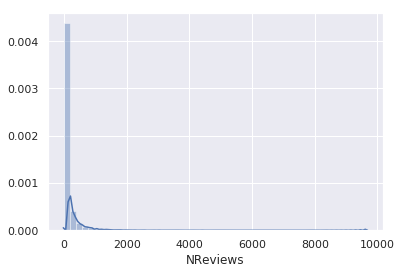

In [91]:
display(df.NReviews.value_counts().head(15))
sns.distplot(df.NReviews)

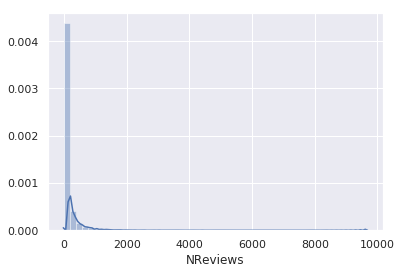

In [92]:
#df['NReviews']=df.NReviews.apply(lambda x: np.log(x+1))
sns.distplot(df.NReviews)

(30.5, -0.5)

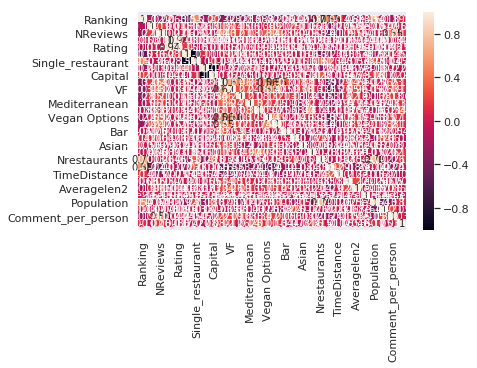

In [93]:
ax = sns.heatmap(df.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)


Кол-вол ресторанов сильно коррелирует с Ranking и Population. Оставим Nrestaurants


In [94]:
new_df=df.drop(['Restaurant_id','City','Cuisine_Style','URL_TA','ID_TA','Not_Capital','Country_name','FirstCommentdt','SecondCommentdt','FirstComment','SecondComment','Ranking','Chain_restaurant','Population','Averagelen1','Averagelen2','Cuisine_Style_old'], axis=1)


In [95]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
Price_Range              38480 non-null float64
NReviews                 50000 non-null float64
sample                   50000 non-null int64
Rating                   50000 non-null float64
Single_restaurant        50000 non-null uint8
Capital                  50000 non-null uint8
Cuisines_q               50000 non-null int64
VF                       50000 non-null int64
European                 50000 non-null int64
Mediterranean            50000 non-null int64
Italian                  50000 non-null int64
Vegan Options            50000 non-null int64
Gluten Free Options      50000 non-null int64
Bar                      50000 non-null int64
French                   50000 non-null int64
Asian                    50000 non-null int64
Pizza                    50000 non-null int64
Nrestaurants             50000 non-null int64
Ranking_per_city         50000 non-null float64
TimeDista

In [96]:
new_df

,Price_Range,NReviews,sample,Rating,Single_restaurant,Capital,Cuisines_q,VF,European,Mediterranean,...,French,Asian,Pizza,Nrestaurants,Ranking_per_city,TimeDistance,Averagel,Restaurant_per_person,Comment_per_person,NReviews_mean
0,500.0,4.0,0,0.0,0,1,2,0,0,0,...,0,0,0,6108,2.122299,NaN,24.2545,0.002793,0.000002,117
1,500.0,97.0,0,0.0,0,1,5,1,1,0,...,0,0,0,475,0.223158,37.0,24.2545,0.000752,0.000154,66
2,500.0,28.0,0,0.0,0,1,1,1,0,0,...,0,0,0,745,1.087248,22.0,24.2545,0.001423,0.000053,238
3,5000.0,202.0,0,0.0,0,1,5,1,1,1,...,0,0,0,7193,0.232031,14.0,24.2545,0.000808,0.000023,138
4,5000.0,162.0,0,0.0,0,1,6,1,1,1,...,0,0,0,380,0.097368,15.0,24.2545,0.000881,0.000376,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,0,0,4,1,0,0,...,0,0,0,2694,0.185598,34.0,24.2545,0.001993,0.000058,168
49996,500.0,542.0,1,3.5,0,1,5,1,1,0,...,1,0,0,6108,1.038147,9.0,24.2545,0.002793,0.000248,117
49997,2.0,4.0,1,4.5,0,1,2,0,0,0,...,0,0,0,1033,1.599226,3127.0,24.2545,0.001105,0.000004,75
49998,500.0,70.0,1,4.0,0,1,5,1,1,0,...,0,0,0,925,0.692973,23.0,24.2545,0.000524,0.000040,67


In [97]:
new_df=new_df.dropna()
new_df

,Price_Range,NReviews,sample,Rating,Single_restaurant,Capital,Cuisines_q,VF,European,Mediterranean,...,French,Asian,Pizza,Nrestaurants,Ranking_per_city,TimeDistance,Averagel,Restaurant_per_person,Comment_per_person,NReviews_mean
1,500.0,97.0,0,0.0,0,1,5,1,1,0,...,0,0,0,475,0.223158,37.0,24.2545,0.000752,0.000154,66
2,500.0,28.0,0,0.0,0,1,1,1,0,0,...,0,0,0,745,1.087248,22.0,24.2545,0.001423,0.000053,238
3,5000.0,202.0,0,0.0,0,1,5,1,1,1,...,0,0,0,7193,0.232031,14.0,24.2545,0.000808,0.000023,138
4,5000.0,162.0,0,0.0,0,1,6,1,1,1,...,0,0,0,380,0.097368,15.0,24.2545,0.000881,0.000376,52
5,5.0,24.0,0,0.0,0,1,3,0,0,0,...,1,0,0,6108,0.833824,5.0,24.2545,0.002793,0.000011,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,79.0,1,4.5,0,0,4,1,0,0,...,0,0,0,2694,0.185598,34.0,24.2545,0.001993,0.000058,168
49996,500.0,542.0,1,3.5,0,1,5,1,1,0,...,1,0,0,6108,1.038147,9.0,24.2545,0.002793,0.000248,117
49997,2.0,4.0,1,4.5,0,1,2,0,0,0,...,0,0,0,1033,1.599226,3127.0,24.2545,0.001105,0.000004,75
49998,500.0,70.0,1,4.0,0,1,5,1,1,0,...,0,0,0,925,0.692973,23.0,24.2545,0.000524,0.000040,67


![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

In [98]:
new_df['sample'].value_counts()

1    25013
0     6253
Name: sample, dtype: int64

In [99]:
df_preproc = new_df
df_preproc.sample(10)

,Price_Range,NReviews,sample,Rating,Single_restaurant,Capital,Cuisines_q,VF,European,Mediterranean,...,French,Asian,Pizza,Nrestaurants,Ranking_per_city,TimeDistance,Averagel,Restaurant_per_person,Comment_per_person,NReviews_mean
27102,500.0,89.0,1,3.5,0,1,3,0,1,1,...,0,0,0,1647,1.906497,151.0,24.2545,0.003251,1.756623e-04,128
18804,500.0,82.0,1,3.5,0,1,4,1,0,0,...,0,1,0,475,0.528421,3.0,24.2545,0.000752,1.298095e-04,66
7699,5.0,37.0,0,0.0,0,0,1,0,0,0,...,0,0,0,3395,0.642415,376.0,24.2545,0.000616,6.708976e-06,136
22087,2.0,7.0,1,4.5,0,1,1,0,0,0,...,0,0,0,7193,1.220075,157.0,24.2545,0.000808,7.865169e-07,138
35796,500.0,417.0,1,3.5,0,1,2,0,1,0,...,1,0,0,6108,0.728062,98.0,24.2545,0.002793,1.906722e-04,117
24483,5.0,70.0,1,5.0,0,0,1,0,0,0,...,0,0,0,3395,0.232695,148.0,24.2545,0.000616,1.269266e-05,136
25862,500.0,733.0,1,4.0,0,1,5,1,1,1,...,1,0,0,6108,0.188441,14.0,24.2545,0.002793,3.351623e-04,117
9844,500.0,63.0,0,0.0,0,1,2,0,0,0,...,0,0,0,1033,0.455954,80.0,24.2545,0.001105,6.737968e-05,75
381,500.0,114.0,0,0.0,0,1,2,0,1,0,...,1,0,0,6108,0.774067,40.0,24.2545,0.002793,5.212620e-05,117
30446,5.0,5.0,1,3.5,0,0,1,0,0,0,...,0,0,0,3395,1.838586,45.0,24.2545,0.000616,9.066183e-07,136


In [100]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31266 entries, 1 to 49999
Data columns (total 24 columns):
Price_Range              31266 non-null float64
NReviews                 31266 non-null float64
sample                   31266 non-null int64
Rating                   31266 non-null float64
Single_restaurant        31266 non-null uint8
Capital                  31266 non-null uint8
Cuisines_q               31266 non-null int64
VF                       31266 non-null int64
European                 31266 non-null int64
Mediterranean            31266 non-null int64
Italian                  31266 non-null int64
Vegan Options            31266 non-null int64
Gluten Free Options      31266 non-null int64
Bar                      31266 non-null int64
French                   31266 non-null int64
Asian                    31266 non-null int64
Pizza                    31266 non-null int64
Nrestaurants             31266 non-null int64
Ranking_per_city         31266 non-null float64
TimeDista

In [101]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
#test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
display(test_data)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

,Price_Range,NReviews,Rating,Single_restaurant,Capital,Cuisines_q,VF,European,Mediterranean,Italian,...,French,Asian,Pizza,Nrestaurants,Ranking_per_city,TimeDistance,Averagel,Restaurant_per_person,Comment_per_person,NReviews_mean
1,500.0,97.0,0.0,0,1,5,1,1,0,0,...,0,0,0,475,0.223158,37.0,24.2545,0.000752,0.000154,66
2,500.0,28.0,0.0,0,1,1,1,0,0,0,...,0,0,0,745,1.087248,22.0,24.2545,0.001423,0.000053,238
3,5000.0,202.0,0.0,0,1,5,1,1,1,1,...,0,0,0,7193,0.232031,14.0,24.2545,0.000808,0.000023,138
4,5000.0,162.0,0.0,0,1,6,1,1,1,1,...,0,0,0,380,0.097368,15.0,24.2545,0.000881,0.000376,52
5,5.0,24.0,0.0,0,1,3,0,0,0,0,...,1,0,0,6108,0.833824,5.0,24.2545,0.002793,0.000011,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,500.0,57.0,0.0,0,1,2,0,0,0,0,...,0,0,0,7193,1.204365,127.0,24.2545,0.000808,0.000006,138
9992,500.0,53.0,0.0,0,1,6,1,0,0,0,...,0,0,0,7193,0.615181,5.0,24.2545,0.000808,0.000006,138
9993,500.0,5.0,0.0,1,0,2,0,1,0,0,...,0,0,0,642,1.155763,197.0,24.2545,0.002995,0.000023,134
9994,500.0,119.0,0.0,0,1,3,0,1,1,0,...,0,0,0,1647,0.493625,51.0,24.2545,0.003251,0.000235,128


**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации.
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [102]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [103]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((6253, 23), (25013, 23), (25013, 22), (20010, 22), (5003, 22))

# Model
Сам ML

In [104]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [105]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [106]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [107]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19935838496901856


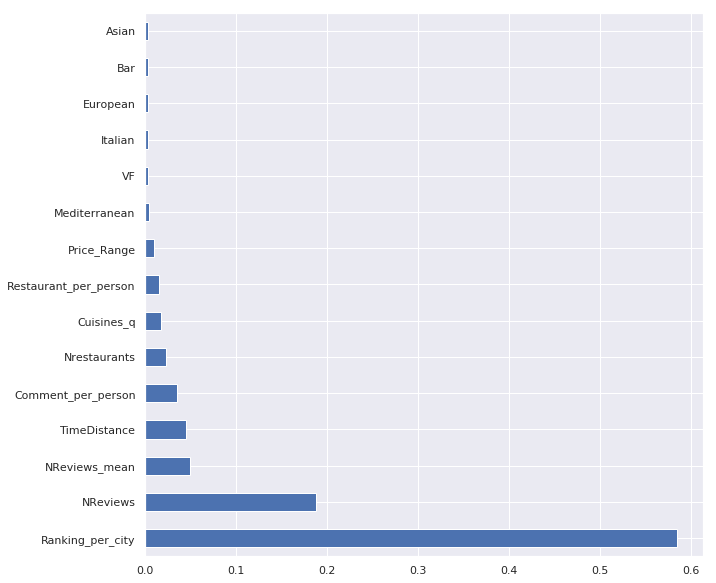

In [108]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [124]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6253 entries, 1 to 9995
Data columns (total 22 columns):
Price_Range              6253 non-null float64
NReviews                 6253 non-null float64
Single_restaurant        6253 non-null uint8
Capital                  6253 non-null uint8
Cuisines_q               6253 non-null int64
VF                       6253 non-null int64
European                 6253 non-null int64
Mediterranean            6253 non-null int64
Italian                  6253 non-null int64
Vegan Options            6253 non-null int64
Gluten Free Options      6253 non-null int64
Bar                      6253 non-null int64
French                   6253 non-null int64
Asian                    6253 non-null int64
Pizza                    6253 non-null int64
Nrestaurants             6253 non-null int64
Ranking_per_city         6253 non-null float64
TimeDistance             6253 non-null float64
Averagel                 6253 non-null float64
Restaurant_per_person    625

In [117]:
#test_data = test_data.drop(['Rating'], axis=1)

KeyError: "['Rating'] not found in axis"

In [119]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [120]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [121]:
predict_submission

array([4.14 , 4.44 , 4.365, ..., 4.79 , 4.205, 4.485])

In [123]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

ValueError: Length of values does not match length of index

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков
#
В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
#